In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons

In [2]:
data =  make_moons(noise=0.3, random_state=0)

In [3]:
X, y = data

In [37]:
X.shape

(100, 2)

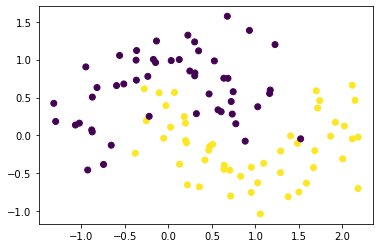

In [4]:
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [26]:
def gini(arr,classes):
    gin=0
    for k in classes:
        pk = len(np.where(arr[:,-1]==k)[0])/len(arr)
        gin = gin + pk*(1-pk)
    return gin

In [27]:
def split(dat,ivar,val):
    left = []
    right = []
    for j in range(len(dat)):
        #print('j=',j)
        if dat[j,ivar] < val:
            left.append(dat[j])
        else:
            right.append(dat[j])
    #print('    in split, lens of left and right =',len(left),len(right))
    left=np.array(left).reshape((-1,len(left[0])))
    right=np.array(right).reshape((-1,len(right[0])))
    return left,right

In [49]:
def best_split(dat,X_types):
    Xdim = len(X_types)
    split_res = []
    for i in range(Xdim): # loop over variables
        print('..checking splits in variable x'+str(i))
        if(X_types[i]=='d'): # discrete variable
            var_vals = list(set(row[i] for row in dat))
            cut_vals = [np.mean([var_vals[k],var_vals[k+1]]) for k in range(len(var_vals)-1)]
        if(X_types[i]=='c'): # continuous variable
            cut_vals = np.linspace(np.min(dat[:,i]),np.max(dat[:,i]),num=nCuts)[1:-1]
        #print('cuts=',cut_vals)
        for cval in cut_vals:
            left,right = split(dat,i,cval)
            giniL,giniR = gini(left,[0,1]), gini(right,[0,1])
            PL,PR=len(left)/len(dat), len(right)/len(dat)
            Gsplit = PL*giniL + PR*giniR
            split_res.append([i,cval,Gsplit])                
    #print('  split res =',split_res)
    #return split_res[np.argmin(np.array(split_res)[:,2])]
    best=split_res[np.argmin(np.array(split_res)[:,2])]
    #print('best split in var: ',best[0],', val= ',best[1])
    return {'var':best[0], 'value':best[1],'left':split(dat,best[0],best[1])[0],
            'right':split(dat,best[0],best[1])[1]}


In [29]:
def val_terminal(dat):
    # returns the value of y={0,1,...,K-1} having the largest population inside data 'dat' 
    y_set = np.array(dat[:,-1])
    argmx=np.argmax(np.unique(y_set,return_counts=True)[1])
    return np.unique(y_set,return_counts=True)[0][argmx]


In [14]:
dataset = np.hstack((X,y.reshape((-1,1))))

In [19]:
np.argmax(np.unique(dataset[:,-1],return_counts=True)[1])

0

node: 
    defined as the output of best_split function.
    It contains the following elements:
    - node['var']: the variable of the best split
    - node['value']: the value of the variable of the best split
    - node['left']: the data for which node['var'] < node['value']
    - node['right']: the data for which node['var'] >= node['value']

In [20]:
arr1=np.array([0,1,2])
arr2=np.array([3,4,5])
print(arr1+arr2)

[3 5 7]


In [45]:
def grow(node,max_depth,min_size,depth):
    # left (right) is the data lying at the left (right) of the node
    left,right = node['left'],node['right']
    del(node['left'])
    del(node['right'])
    #check for empty left or right, leading to a terminal
    if len(left)==0 or len(right)==0:
        print('  empty left or right')
        # below, note that either 'left' or 'right' is empty, so left+right is 1 of them
        # since it is a terminal node, then node['left'] and node['right'] 
        #       contain no data, but just the majority-vote value given by 'val_terminal'
        node['left'] = node['right'] = val_terminal(left+right)
        return
    # check for max depth, leading to terminal
    if depth >= max_depth:
        print('  max depth reached')
        node['left'],node['right'] = val_terminal(left), val_terminal(right)
        print('  vals, left: ',node['left'],' right: ',node['right'])
        return
    # grow left branch
    if(len(left)<=min_size): #unless minimum size
        node['left']=val_terminal(left)
        print('  min size found in left branch. Left val_terminal = ',node['left'])
    else:
        print('..growing left branch')
        node['left']=best_split(left,X_types)
        print('depth: ',depth,', var: x'+str(node['left']['var']),', val:',node['left']['value'])
        grow(node['left'],max_depth,min_size,depth+1)
    # grow right branch
    if(len(right)<=min_size): #unless minimum size
        node['right']=val_terminal(right)
        print('  min size found in right branch. Right val_terminal = ',node['right'])
    else:
        print('..growing right branch')
        node['right']=best_split(right,X_types)
        print('depth: ',depth,', var: x'+str(node['right']['var']),', val:',node['right']['value'])
        grow(node['right'],max_depth,min_size,depth+1)

In [68]:
def build_tree(train,max_depth,min_size):
    root = best_split(train,X_types)
    print('root node.  var, val:',root['var'],root['value'])
    grow(root,max_depth,min_size,1)
    return root

In [33]:
def predict(node,row):
    if row[node['var']] < node['value']:
        # a node with childs is a dict, otherwise it is a value, because it is a terminal
        if isinstance(node['left'],dict):
            # everytime node['left'] is used, 
            # we go deep by one level in the tree from the left 
            return predict(node['left'],row)
        else:
            return node['left']
    else:
        if isinstance(node['right'],dict):
            return predict(node['right'],row)
        else:
            return node['right']

In [72]:
def decision_tree(train,test,max_depth,min_size):
    tree=build_tree(train,max_depth,min_size)
    print('*********************************')
    print('tree=\n',tree)
    predictions=[]
    for row in test:
        predictions.append(predict(tree,row))
    return predictions

In [62]:
def score(obs,pred):
    #print('lens: ',len(obs),len(pred))
    correct = 0
    for i in range(len(obs)):
        if obs[i] == pred[i]:
            correct += 1
    return correct / len(obs)

# Main routine

## using decision tree from scratch

In [8]:
dataset = np.hstack((X,y.reshape((-1,1))))

#split training and test
np.random.seed(1)
perm = np.random.permutation(len(dataset))
dataset = dataset[perm]
test_size = int(0.4*len(dataset))
test_data = dataset[:test_size]
train_data = dataset[test_size:]

In [37]:
X_types=['c','c'] # types of variables
nCuts=40  # no. of cuts to evaluate the splits if variable is continuous

In [73]:
predicted = decision_tree(train_data, test_data, 4, 1)

..checking splits in variable x0
..checking splits in variable x1
root node.  var, val: 1 -0.009327970525967011
..growing left branch
..checking splits in variable x0
..checking splits in variable x1
depth:  1 , var: x0 , val: -0.5964755582706589
..growing left branch
..checking splits in variable x0
..checking splits in variable x1
depth:  2 , var: x0 , val: -0.7443581969384301
  min size found in left branch. Left val_terminal =  0.0
  min size found in right branch. Right val_terminal =  0.0
..growing right branch
..checking splits in variable x0
..checking splits in variable x1
depth:  2 , var: x1 , val: -0.08268855718990309
..growing left branch
..checking splits in variable x0
..checking splits in variable x1
depth:  3 , var: x0 , val: 0.17543689774672622
  max depth reached
  vals, left:  1.0  right:  1.0
..growing right branch
..checking splits in variable x0
..checking splits in variable x1
depth:  3 , var: x1 , val: -0.07440121961667097
  max depth reached
  vals, left:  0.0 

In [51]:
predicted

[0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0]

In [52]:
test_data[:,-1]

array([0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
       0., 1., 1.])

In [63]:
model_score = score(test_data[:,-1], predicted)
print(model_score)

0.95


## using decision tree from sklearn

In [25]:
classifier = DecisionTreeClassifier(criterion='gini',max_depth=9)

In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
classifier.fit(train_data[:,:-1], train_data[:,-1])

DecisionTreeClassifier(max_depth=9)

In [28]:
print(classifier.score(train_data[:,:-1], train_data[:,-1]))
classifier.score(test_data[:,:-1], test_data[:,-1])

1.0


0.8

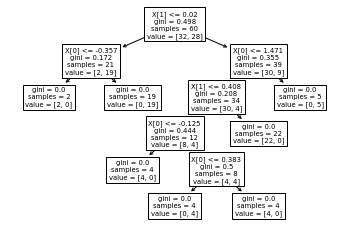

In [29]:
plot_tree(classifier)
plt.show()

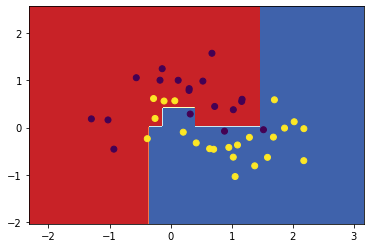

In [30]:
x_min, x_max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
y_min, y_max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
#plt.scatter(X[:,0],X[:,1],c=y)
plt.scatter(test_data[:,0],test_data[:,1],c=test_data[:,-1])
plt.show()

## using Logistic regression from sklearn

In [81]:
clf = LogisticRegression(penalty='none',solver='lbfgs')

In [82]:
clf.fit(train_data[:,:-1], train_data[:,-1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
clf.score(test_data[:,:-1], test_data[:,-1])

0.85

In [125]:
xx=np.linspace(-1.5,3,100)
yy=np.linspace(-1.5,3,100)
xx, yy = np.meshgrid(xx, yy)
Xfull = np.hstack((xx.reshape((-1,1)), yy.reshape((-1,1)) ))

probas = clf.predict_proba(Xfull)
probs_1_grid = probas[:,1].reshape((100,100))

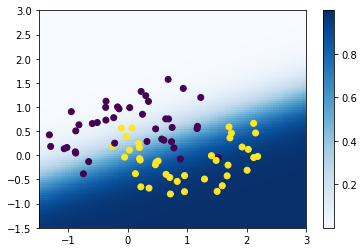

In [127]:
plt.pcolormesh(xx,yy,probs_1_grid,cmap=plt.cm.get_cmap('Blues'))
plt.colorbar()
plt.scatter(train_data[:,:-1][:,0],train_data[:,:-1][:,1],c=train_data[:,-1])
plt.show()